In [2]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

!pip install moviepy

Ultralytics YOLOv8.0.235 🚀 Python-3.10.6 torch-2.2.2 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 456.3/460.4 GB disk)
    PyYAML (>=5.1.*)
            ~~~~~~^


In [34]:
from ultralytics import YOLO
from IPython.display import display, Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = '/opt/homebrew/bin/ffmpeg'
from moviepy.editor import VideoFileClip, concatenate_videoclips
import pickle
import json

### Configurations

In [4]:
RUN_DIR = 'yolo-in-play-classifier-model'
# video_path = '/kaggle/input/full-baseball-videos/Mexico vs Japan Full Game 2023.mp4'
# video_path = '/kaggle/input/full-baseball-videos/CPBL Game Jun 28.mp4'
video_path = 'US vs Japan World Baseball Classic Final.mp4'
# output_video_path = 'extracted-baseball-videos-mexico-vs-japan.mp4'
# output_cut_path = 'cut-baseball-videos-mexico-vs-japan.mp4'

### Model predictions

In [5]:
model = YOLO(f"{RUN_DIR}/in-play-classifier-model.pt")
scoreboard_model = YOLO(f'{RUN_DIR}/scoreboard-detection-model.pt')

def predict(img):
    labels = ['in-play', 'not-in-play', 'ready-to-play']
    results = model.predict(img, verbose=False)
    max_index = torch.argmax(results[0].probs.data).item()
    return labels[max_index]

def detect_scoreboard(img):
    detections = scoreboard_model.predict(img, verbose=False)
    if detections[0].boxes.conf.numel() > 0:
        confidences_np = detections[0].boxes.conf.cpu().numpy()
        confidences = confidences_np[0]
    else:
        confidences = 0
    return confidences

### Extract frames

In [6]:
fps = 29.97
def extract_frames(video_path, interval=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    success, frame = cap.read()
    count = 0
    current_sec = 1

    with tqdm(total=total_frames_count, desc="Extracting frames") as pbar:
        while success:
            if count > fps * current_sec:
                frames.append(frame)
                current_sec += 1
            success, frame = cap.read()
            count += 1
            pbar.update(1)

    cap.release()
    return frames

In [7]:
label_to_num = {
    'not-in-play': 0,
    'ready-to-play': 1,
    'in-play': 2
}

def classify_frames(frames):
    results = []
    confidences = []
    count = 0
    for frame in tqdm(frames, desc="Classifying frames"):
        count += 1
        confidence = detect_scoreboard(frame)
        confidences.append(confidence)
        label = predict(frame)
        results.append(label_to_num[label])
    return results, confidences

In [8]:
def moving_average(data, window_size):
    pad_size = (window_size - 1) // 2
    padded_data = np.pad(data, (pad_size, pad_size), mode='edge')
    moving_avg = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    return moving_avg

def filter_results(results, confidences):
    filtered_results = []
    for i in range(len(results)):
        if(confidences[i] >= 0.9 and results[i] < 1):
            filtered_results.append(2 * confidences[i])
        elif(confidences[i] > 0.6):
            filtered_results.append(results[i] * 0.9)
        else:
            filtered_results.append(results[i] * confidences[i])
    
    return filtered_results  

def plot_results(results, interval=1):
    x = [i * interval for i in range(len(results))]
    y = results

    plt.figure(figsize=(24, 12))
    plt.plot(x, y, marker='o')
    plt.xlabel('Time (sec)')
    plt.ylabel('Game State')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.yticks([0, 1, 2], ['not-in-play', 'ready-to-play', 'in-play'])
    plt.title('Baseball Game State Over Time')
    plt.grid(True)
    plt.show()
    
def plot_conf_results(confidences, interval=1):
    x = [i * interval for i in range(len(confidences))]
    y = confidences

    plt.figure(figsize=(24, 12))
    plt.plot(x, y, marker='o')
    plt.xlabel('Time (sec)')
    plt.ylabel('Confidences')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.title('Confidence Values Over Time')
    plt.grid(True)
    plt.show()


In [12]:
frames = extract_frames(video_path, interval=1)

Extracting frames: 100%|██████████| 339800/339800 [01:35<00:00, 3555.80it/s]


In [13]:
def load_pkl(file_path):
    with open(file_path, "rb") as f:
        loaded_list = pickle.load(f)
        return loaded_list

# results_path = "results_better.pkl"
# results = load_pkl(results_path)

# confidences_path = "confidences_usa_japan.pkl"
# confidences = load_pkl(confidences_path)

# smoothed_results_path = "smoothed_results_usa_japan.pkl"
# smoothed_results = load_pkl(smoothed_results_path)

print(len(frames))
results, confidences = classify_frames(frames)

print(confidences[9997:])

11337


Classifying frames: 100%|██████████| 11337/11337 [16:42<00:00, 11.31it/s]

[0, 0.32918856, 0.8365817, 0.70800817, 0.811991, 0.6629286, 0.6950231, 0.9035728, 0, 0.775723, 0.890472, 0, 0, 0.51203924, 0.66384155, 0.34089446, 0.37050393, 0.52253556, 0.3791525, 0.5436766, 0.5085255, 0.42177784, 0.43229792, 0.45801795, 0.36952046, 0.45310304, 0.34040597, 0.44453177, 0.76844853, 0.8599317, 0.63929, 0.83368003, 0, 0, 0, 0, 0, 0.29157838, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6658709, 0.8544215, 0.8882246, 0.84177923, 0.8123278, 0.5426524, 0.7320967, 0.8259769, 0.80263424, 0.59383404, 0.8481272, 0.8146092, 0.71320945, 0.78935564, 0.61432034, 0.43277448, 0.54079884, 0.8727869, 0.46113834, 0.4291039, 0.7376813, 0.873892, 0.68678737, 0.72857785, 0.85786825, 0.7758026, 0.6201385, 0.53877705, 0.6070227, 0.40877846, 0.33663595, 0, 0, 0, 0.745365, 0, 0.75248945, 0.55757827, 0.8418023, 0.46654084, 0.6381211, 0.57277626, 0.8901901, 0.7853812, 0.51821816, 0, 0.7886728, 0.32167253, 0.7901519, 0, 0.73945576, 0, 0, 0.4391987, 0, 0, 0, 0, 0, 0

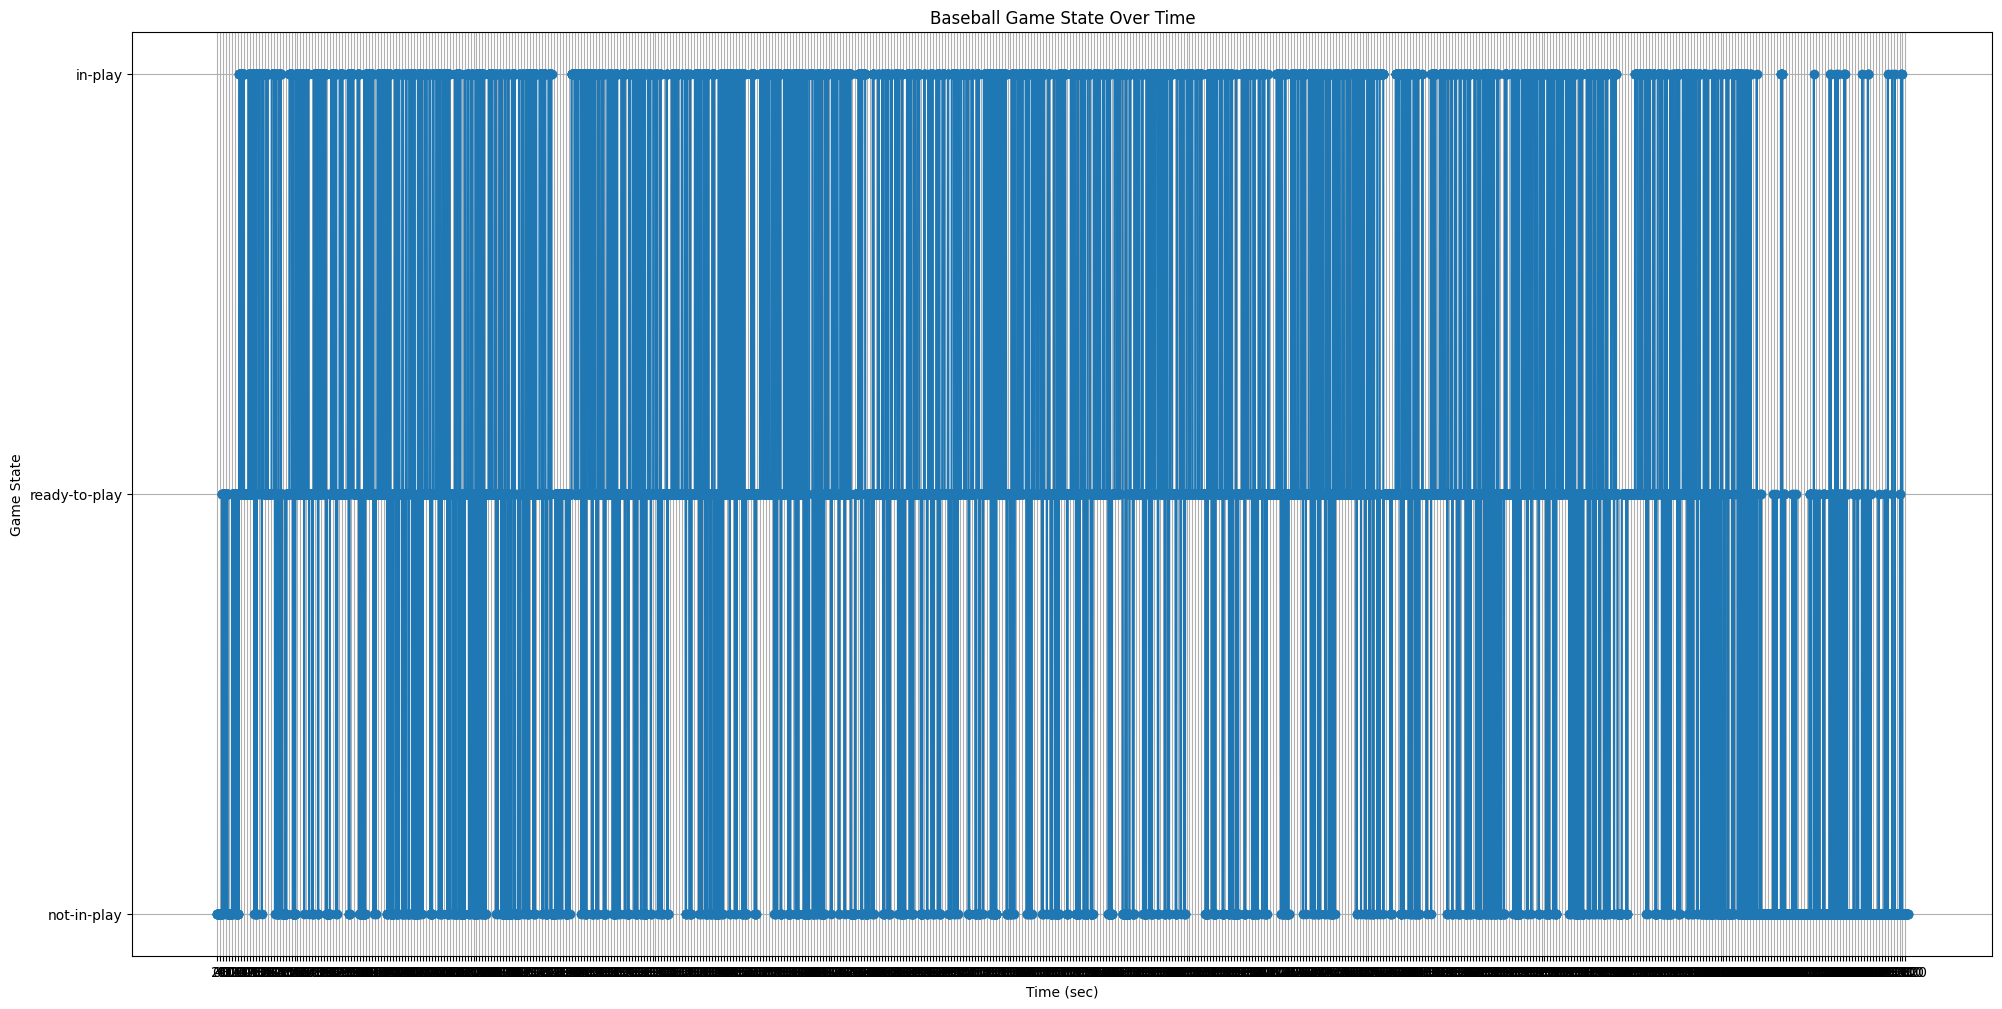

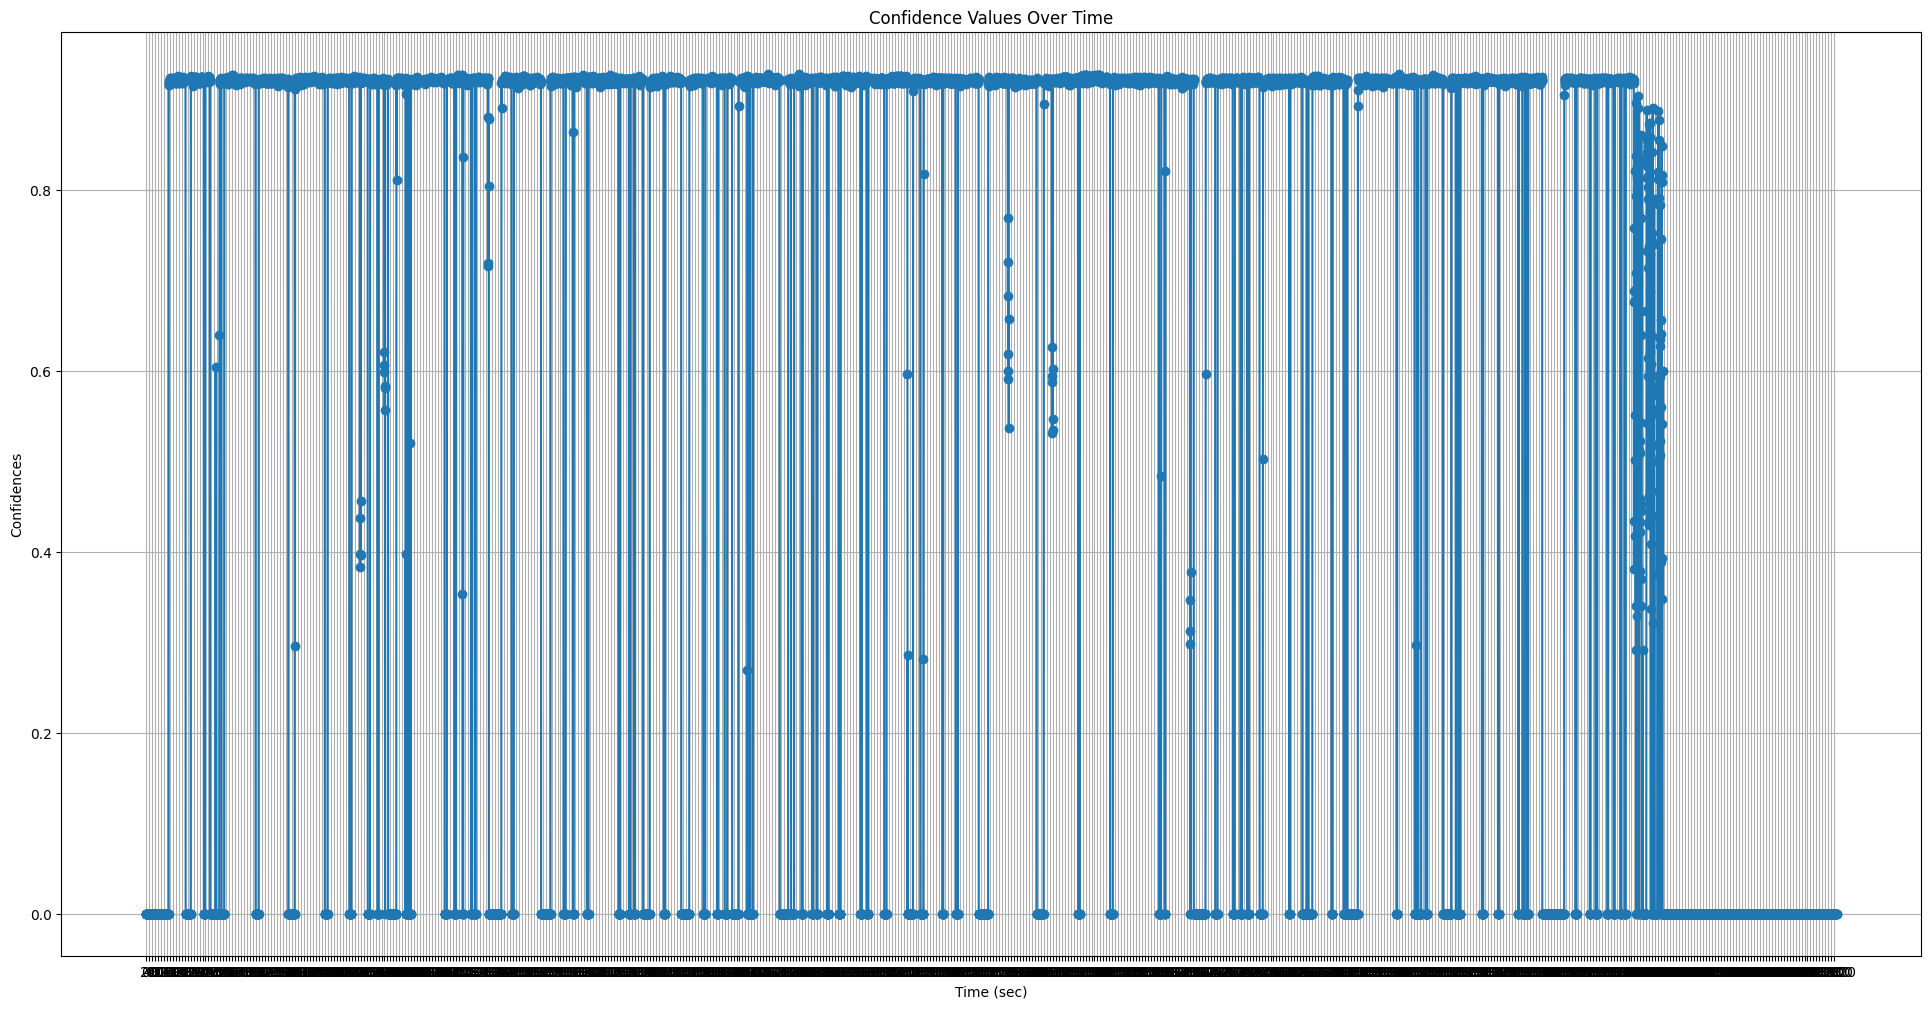

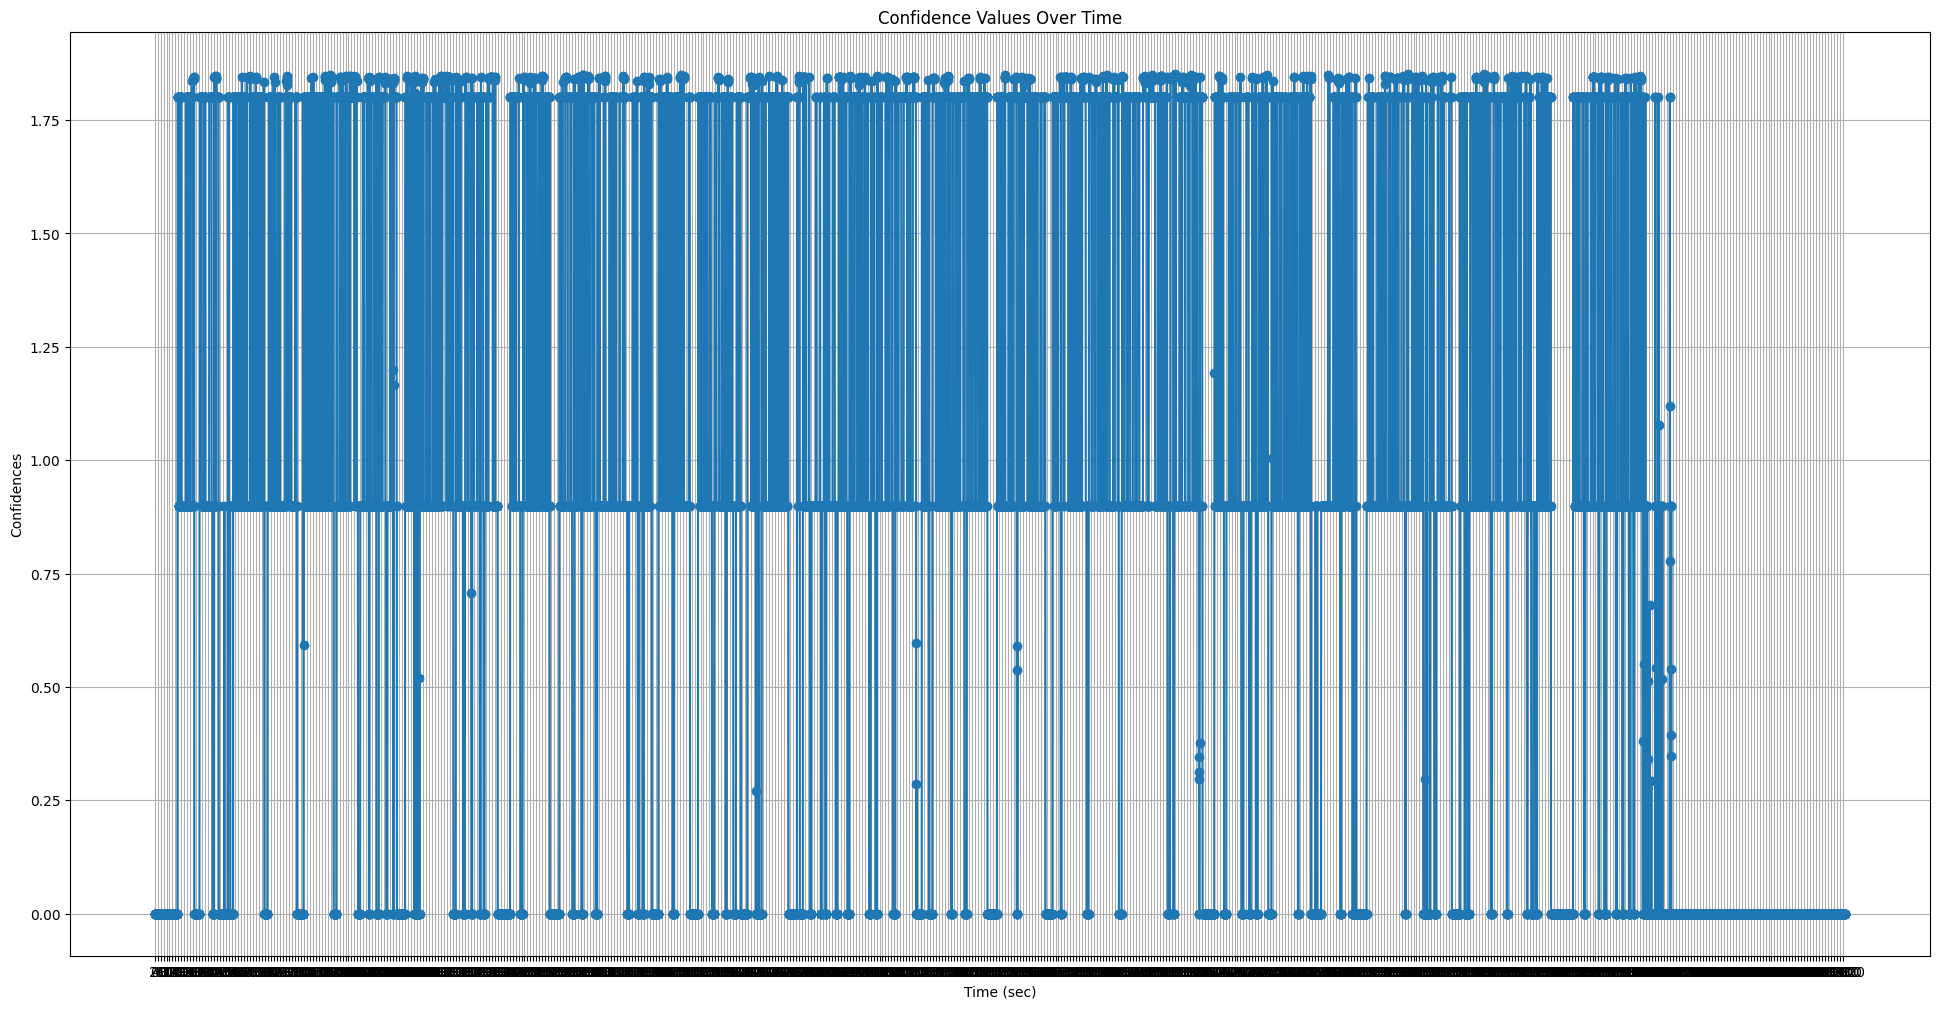

In [14]:
plot_results(results, interval=1)

smoothed_confidences = moving_average(confidences, 3)

plot_conf_results(confidences, interval=1)

filtered_results =  filter_results(results, confidences)

plot_conf_results(filtered_results, interval=1)

5427


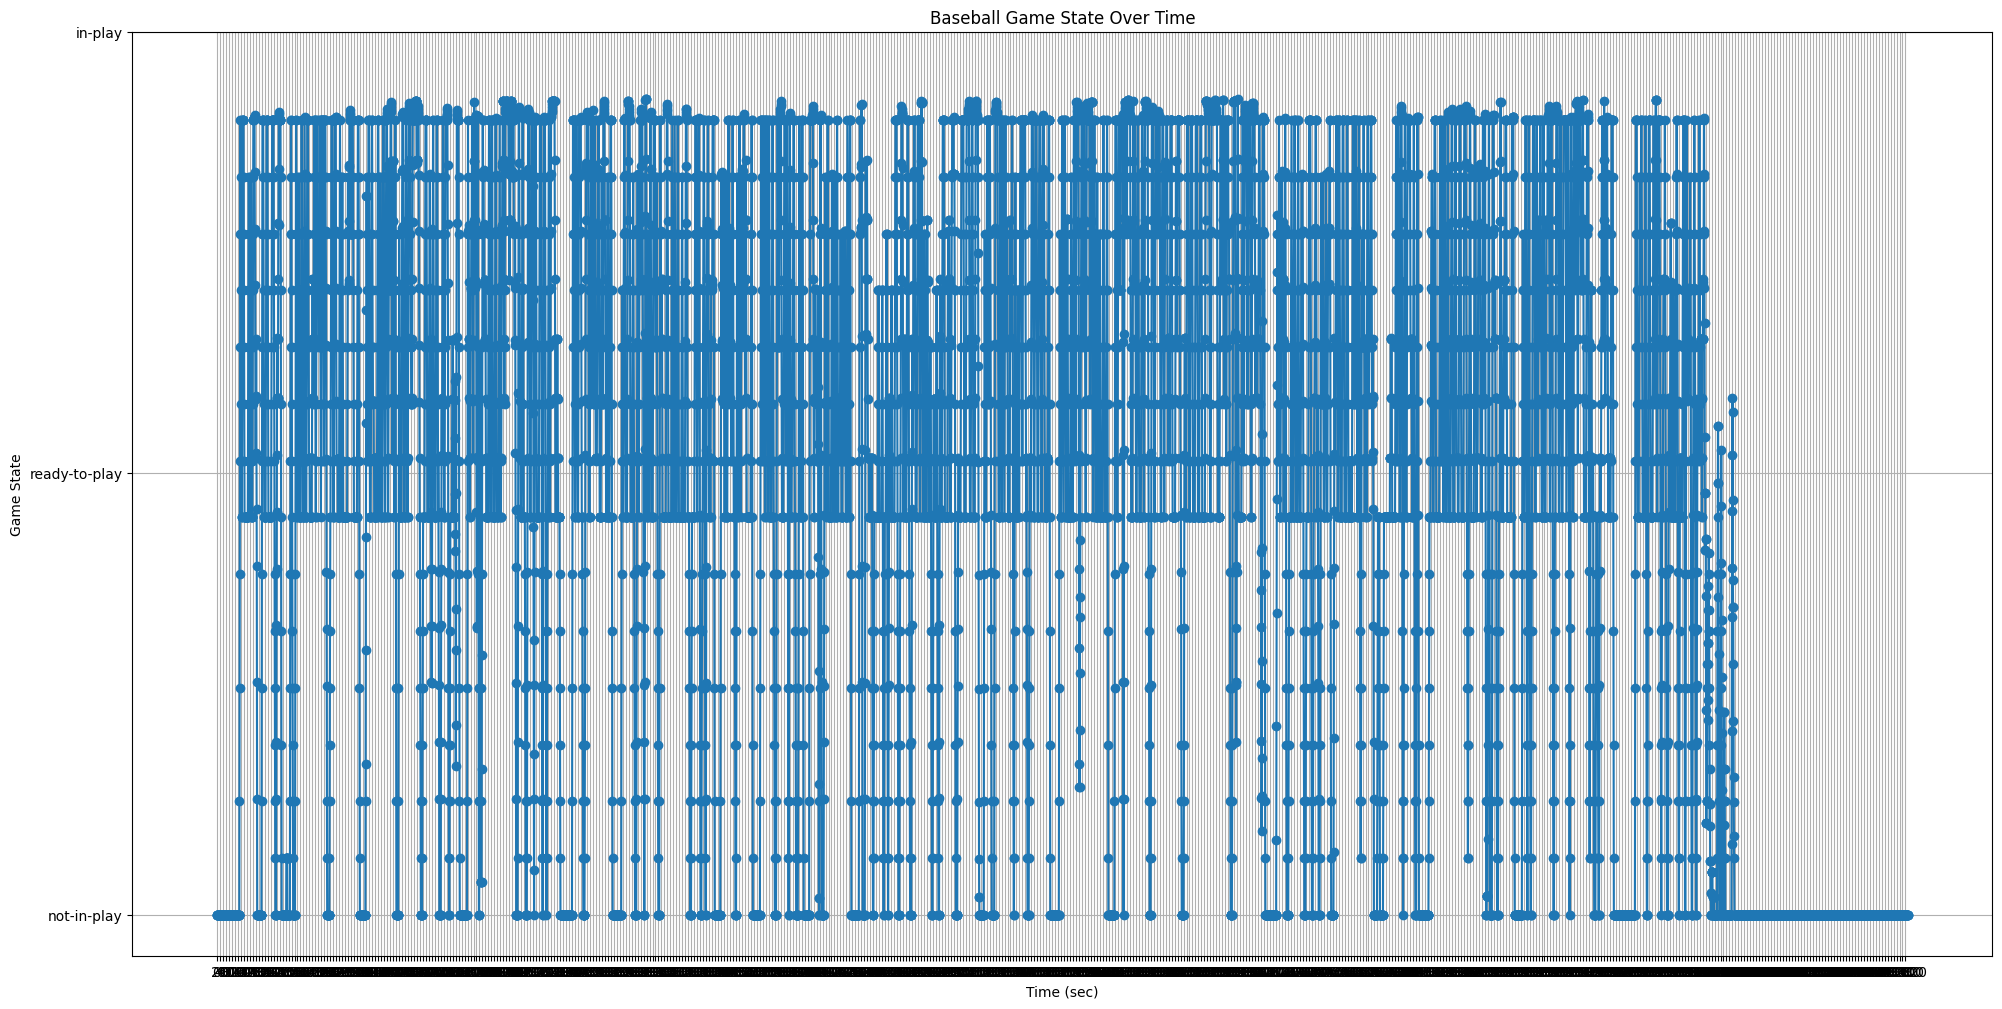

In [15]:
window_size = 7

smoothed_results = moving_average(filtered_results, window_size)
count = 0
for s in smoothed_results:
    if s < 1:
        count += 1
print(count)

# Plot smoothed results
plot_results(smoothed_results, interval=1)

In [16]:
def check_valid(results, i):
    if i == 0:
        if (results[i] == 0 or results[i+1] == 0):
            return False
    elif i == len(results) - 1:
        if (results[i] == 0 or results[i-1] == 0):
            return False
    else:
        if results[i] == 0 or results[i+1] == 0 or results[i-1] == 0:
            return False
    return True
        
def get_clip_segments(smoothed_results, threshold):
    # filtered_frames = []
    clip_segments = []
    # print(len(results), len(smoothed_results))
    for i in range(len(smoothed_results)):
        if smoothed_results[i] > threshold:
            clip_segments.append(i)
    return clip_segments

In [27]:
def concatenate_video_clips(input_video_path, output_video_path, clip_segments):
    clips = []
    video = VideoFileClip(input_video_path)

    for idx, (start_time_sec, end_time_sec) in enumerate(tqdm(clip_segments, desc="Clipping segments")):
        clip = video.subclip(start_time_sec - 0.5, end_time_sec + 0.5)
        clips.append(clip)

    final_clip = concatenate_videoclips(clips)

    final_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")
    print(f"Concatenated video saved to {output_video_path}")

In [18]:
def save_list(lst, name):
    file_path = f'{name}.pkl'

    with open(file_path, 'wb') as file:
        pickle.dump(lst, file)

    print(f'List saved to {file_path}')

In [19]:
# save_list(smoothed_results, 'smoothed_results')
# save_list(results, 'results')
# save_list(confidences, 'confidences')
# save_list(frames, 'frames')
# save_list(clip_segments, 'clip_segments')

In [39]:
threshold = 1
print(fps)
print(smoothed_results[9960:9997])

29.97
[     1.3049      1.3049      1.3049      1.4391      1.4327       1.426      1.4199      1.5484       1.677      1.8056         1.8      1.6714      1.5429      1.3402       1.083     0.95446     0.95446     0.95446     0.82588     0.82588     0.85016     0.85016     0.72159     0.46445     0.20731     0.20731
     0.20731     0.25714     0.25714     0.25714     0.25714     0.51429     0.56895     0.56895     0.44037      0.4874     0.61597]
[9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 10063, 10064, 10085, 10159, 10160, 10161]


### Post processing

In [40]:
def list_to_ranges(lst):
    if not lst:
        return []
    
    lst.sort()
    ranges = []
    start = lst[0]
    end = lst[0]

    for num in lst[1:]:
        if num == end + 1:
            end = num
        else:
            if ranges and (num - end) < 5:
                # Merge with the last range
                ranges[-1] = (ranges[-1][0], end)
            elif end - start > 1:
                ranges.append((start, end + 3))
            start = num
            end = num

    ranges.append((start, end))
    return ranges

Clip segments: [(154, 167), (168, 219), (221, 235), (238, 268), (302, 319), (327, 347), (364, 388), (402, 432), (493, 537), (541, 555), (561, 578), (582, 597), (600, 696), (698, 736), (762, 782), (784, 831), (835, 849), (873, 920), (939, 956), (1000, 1028), (1032, 1056), (1062, 1088), (1090, 1104), (1108, 1187), (1190, 1202), (1219, 1229), (1237, 1256), (1260, 1278), (1280, 1361), (1392, 1413), (1421, 1437), (1443, 1482), (1506, 1525), (1527, 1553), (1576, 1587), (1593, 1599), (1605, 1694), (1697, 1742), (1745, 1755), (1762, 1769), (1778, 1833), (1836, 1901), (1905, 2004), (2020, 2038), (2043, 2059), (2082, 2102), (2104, 2124), (2130, 2147), (2159, 2180), (2188, 2231), (2234, 2272), (2277, 2399), (2403, 2420), (2422, 2448), (2470, 2497), (2500, 2568), (2574, 2611), (2614, 2628), (2632, 2720), (2724, 2742), (2750, 2776), (2785, 2826), (2829, 2896), (2899, 2916), (2922, 2955), (2969, 2990), (3010, 3029), (3046, 3061), (3063, 3078), (3083, 3099), (3113, 3127), (3138, 3218), (3221, 3239), 

In [42]:
clip_segments = get_clip_segments(smoothed_results, threshold)
print(clip_segments[-50:])
clip_segments = list_to_ranges(clip_segments)
print(f"Clip segments: {clip_segments}")

[9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 10063, 10064, 10085, 10159, 10160, 10161]
Clip segments: [(154, 167), (168, 219), (221, 235), (238, 268), (302, 319), (327, 347), (364, 388), (402, 432), (493, 537), (541, 555), (561, 578), (582, 597), (600, 696), (698, 736), (762, 782), (784, 831), (835, 849), (873, 920), (939, 956), (1000, 1028), (1032, 1056), (1062, 1088), (1090, 1104), (1108, 1187), (1190, 1202), (1219, 1229), (1237, 1256), (1260, 1278), (1280, 1361), (1392, 1413), (1421, 1437), (1443, 1482), (1506, 1525), (1527, 1553), (1576, 1587), (1593, 1599), (1605, 1694), (1697, 1742), (1745, 1755), (1762, 1769), (1778, 1833), (1836, 1901), (1905, 2004), (2020, 2038), (2043, 2059), (2082, 2102), (2104, 2124), (2130, 2147), (2159, 2180), (2188, 2231), (2234, 2272), (

In [43]:
json_file_path = 'config.json'

with open(json_file_path, 'r') as file:
    config = json.load(file)

video_path = config['original_video_path']
output_video_path = config['output_video_path']

# plot_conf_results(clip_segments[-50:])

# plot_conf_results(confidences[9960:9997])

# plot_conf_results(smoothed_results[9960:9997])

concatenate_video_clips(video_path, output_video_path, clip_segments)

python(84237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(84241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(84243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(84253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(84255

Moviepy - Building video extracted-highlights_usa_japan.mp4.
MoviePy - Writing audio in extracted-highlights_usa_japanTEMP_MPY_wvf_snd.mp4




python(84662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
















































python(84691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.






































python(84715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.




























































































































































python(84781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.




































































































































python(84839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.






































































































































